# Segmentez des clients d'un site e-commerce

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


Ressources : https://www.kaggle.com/olistbr/brazilian-ecommerce


# Sommaire
 1. [Organisation des données](#Organisation-des-données)
 2. [Exploration des données](#Exploration-des-données)
  1. [Clients](#Customers)
  2. [Géolocalisation](#geolocation)
  3. [Lignes de commandes](#order_items)
  4. [Paiements](#order_payments)
  5. [Avis](#order_reviews)
  6. [Commandes](#orders)
  7. [Produits](#products)
  8. [Vendeurs](#sellers)
  
 3. [Regroupement des jeux de données](#Regroupement-des-jeux-de-données)
  1. [Valeurs manquantes](#Valeurs-manquantes)
 4. [Conclusion](#Conclusion)

# Organisation des données

![](../img/data_schema.png)

|Fichier                          | Description |
| :------------------------------ | :---------- |
|olist_customers_dataset.csv      | Liste des clients            |
|olist_geolocation_dataset.csv    | Coordonnées GPS des villes concernant les clients et les vendeurs|
|olist_order_items_dataset.csv    | Lignes de commandes            |
|olist_order_payments_dataset.csv | Paiements par le client            |
|olist_order_reviews_dataset.csv  | Appréciation du client            |
|olist_orders_dataset.csv         | Entêtes de commandes            |
|olist_products_dataset.csv       | Produits qui ont été vendus            |
|olist_sellers_dataset.csv        | Vendeurs des produits            |


# Exploration des données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from olist import Olist
sns.set()

In [2]:
import folium
from folium import plugins
from folium.plugins import HeatMap

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%load_ext pycodestyle_magic
# %pycodestyle_on

In [6]:
olist = Olist()
base_directory = olist.base_directory

In [7]:
# Chargement des données
customers = pd.read_csv(base_directory +
                        "olist_customers_dataset.csv")
geolocation = pd.read_csv(base_directory +
                          "olist_geolocation_dataset.csv")
order_items = pd.read_csv(base_directory +
                          "olist_order_items_dataset.csv")
order_payments = pd.read_csv(base_directory +
                             "olist_order_payments_dataset.csv")
order_reviews = pd.read_csv(base_directory +
                            "olist_order_reviews_dataset.csv")
orders = pd.read_csv(base_directory +
                     "olist_orders_dataset.csv")
products = pd.read_csv(base_directory +
                       "olist_products_dataset.csv")
sellers = pd.read_csv(base_directory +
                      "olist_sellers_dataset.csv")
translations = pd.read_csv(base_directory +
                           "product_category_name_translation.csv")

# Customers
Ce jeu de données contient des informations sur les clients et leur localisation.

Chaque commande est attribuée à un client unique (**customer_id**). Cela signifie qu'un même client obtiendra des identifiants différents pour des commandes différentes. Le champ **customer_unique_id** est l'identifiant d'un même client dans l'ensemble des données.


 - **customer_id** : identifiant relatif aux commandes. Chaque commande a un identifiant client unique. 
 - **customer_unique_id** : identifiant unique d'un client.
 - **customer_zip_code_prefix** : cinq premiers chiffres du code postal du client
 - **customer_city** : ville dans laquelle réside le client
 - **customer_state** : Etat dans lequel réside le client
 

In [8]:
print(f"{customers.shape[0]} lignes {customers.shape[1]} colonnes")

99441 lignes 5 colonnes


In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [10]:
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [11]:
print("Valeurs manquantes")
customers.isnull().sum()

Valeurs manquantes


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

## customer_id
Identifiant relatif aux commandes. Chaque commande a un identifiant client unique.

In [12]:
nb_customers = len(customers['customer_unique_id'].unique())
nb_orders = customers.shape[0]

print(f"{nb_customers} client référencés pour {nb_orders} commandes")

96096 client référencés pour 99441 commandes


## customer_unique_id
Identifiant unique d'un client. 

Les données ne sont pas uniques car un client peut avoir passé plusieurs commandes.
Il y a 2997 client qui ont passé au moins 2 commandes. En moyenne un client passe une commande et au maximum 17 commandes.

In [13]:
df = customers.groupby('customer_unique_id').customer_id.nunique()
print(f"{df[df > 1].count()} clients ont passé au moins 2 commandes")

2997 clients ont passé au moins 2 commandes


In [14]:
df.shape

(96096,)

In [15]:
df.describe()

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: customer_id, dtype: float64

In [16]:
# Classement du nombre de commandes par client
df = customers.groupby('customer_unique_id').count()
nb_order_by_customer = df.groupby('customer_id').count()['customer_state']
nb_order_by_customer = nb_order_by_customer.rename("nb_order_by_customer")
print("Nombre de commandes par clients")
nb_order_by_customer

Nombre de commandes par clients


customer_id
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: nb_order_by_customer, dtype: int64

## customer_zip_code_prefix
Cinq premiers chiffres du code postal du client


In [17]:
print(f"{len(customers['customer_zip_code_prefix'].unique())} Code postaux")

14994 Code postaux


## customer_city
Ville dans laquelle réside le client. 

Il y a 4119 villes référencées. Les villes de **São Paulo**, de **Rio de Janeiro** et de **Belo Horizonte** sont celles qui commandent le plus alors que les villes de **Caraíbas**, de **Pedro Gomes**, de **Lagoão** sont celles qui commandent le moins.

In [18]:
print(f"{len(customers['customer_city'].unique())} villes")

4119 villes


In [19]:
df = customers.groupby('customer_city').count()
df['customer_id'].sort_values(ascending=False)

customer_city
sao paulo         15540
rio de janeiro     6882
belo horizonte     2773
brasilia           2131
curitiba           1521
                  ...  
pedro velho           1
japoata               1
caraibas              1
pedro gomes           1
lagoao                1
Name: customer_id, Length: 4119, dtype: int64

## customer_state
Etat dans lequel réside le client. Cela correspond au [code des états au Bresil](https://brazil-help.com/brazilian_states.htm). 

![](img/state_brazil.jpg)

Les états de **São Paulo**, de **Rio de Janeiro** et de **Belo Horizonte** sont ceux qui commandent le plus alors que les états de **Rio Branco**, de **Macapá** et de **Boa Vista** sont ceux qui commandent le moins.

In [20]:
print(f"{len(customers['customer_state'].unique())} états référencés sur 27")

27 états référencés sur 27


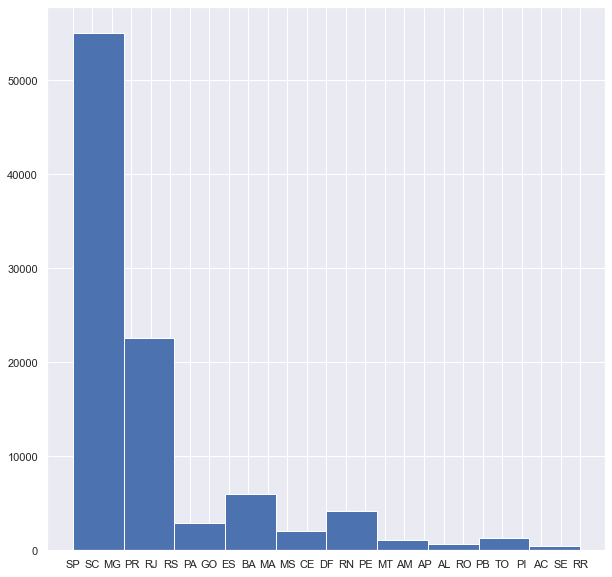

In [21]:
df = customers.drop_duplicates(subset=['customer_unique_id'])
plt.figure(figsize=(10, 10))
df['customer_state'].hist()
plt.show()

In [22]:
df_state = df.groupby('customer_state').count()
city_min = df_state['customer_id'].sort_values().head()
city_max = df_state['customer_id'].sort_values().tail()

print(f"Les 5 villes qui commandent le plus {city_max}")
print(f"Les 5 villes qui commandent le moins {city_min}")

Les 5 villes qui commandent le plus customer_state
PR     4882
RS     5277
MG    11255
RJ    12377
SP    40295
Name: customer_id, dtype: int64
Les 5 villes qui commandent le moins customer_state
RR     45
AP     67
AC     77
AM    143
RO    239
Name: customer_id, dtype: int64


# geolocation
Ce jeu de données contient des informations sur les codes postaux brésiliens et leurs coordonnées lat/lng. 

Il y a 100163 coordonnées référencées. Les champs **geolocation_lat** et **geolocation_lng** correspondant à la latitude et la longitude. Les champs **geolocation_zip_code_prefix**, **geolocation_city** et  **geolocation_state**, sont les mêmes que ceux utilisés dans le jeu de données **customers**. 

Le lien avec les autres tables est fait avec le champ **geolocation_zip_code_prefix**, cependant cette donnée n'est pas unique. Il sera donc nécessaire de ne garder qu'une seule coordonnée pour un code postal afin de conserver des données uniformes. Il y a 19015 codes postaux uniques sur 100163 lignes.

Lorsque l'on ajoute au jeu de données **customers**, les informations de longitude et de latitude, il y a 278 clients qui n'ont pas de coordonnées en rapport avec le code postal. 

On remarque que l'ensemble du territoire est couvert, mais que, en plus, certaines coordonnées concernent l'Argentine ou le Portugal.

In [23]:
print(f"{geolocation.shape[0]} lignes {geolocation.shape[1]} colonnes")

1000163 lignes 5 colonnes


In [24]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [25]:
geolocation.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [26]:
print("Valeurs manquantes")
geolocation.isnull().sum()

Valeurs manquantes


geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [27]:
geo_unique = len(geolocation['geolocation_zip_code_prefix'].unique())
print(f"{geo_unique} codes postaux uniques")

19015 codes postaux uniques


In [28]:
# On ne conserve qu'une seule coordonnées afin d'avoir des données unifiées
geolocation = geolocation.drop_duplicates(
    subset=['geolocation_zip_code_prefix'],
    keep="first")

In [29]:
# Ajoute à la table customer les coordonnées GPS
customers_geo = customers.merge(
    geolocation[['geolocation_lat',
                 'geolocation_lng',
                 'geolocation_zip_code_prefix']],
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
customers_geo.drop('geolocation_zip_code_prefix', axis=1, inplace=True)

In [30]:
geo_not_found = customers_geo['geolocation_lat'].isna().sum()
print(f"{geo_not_found} coordonnées non trouvées")

278 coordonnées non trouvées


In [31]:
brazil_map = folium.Map(location=[-14.242914500000001, -53.1892665],
                        zoom_start=4)
customers_geo = customers_geo.dropna()
heat_data = [[row['geolocation_lat'],
              row['geolocation_lng']]
             for index, row in customers_geo.iterrows()]
HeatMap(heat_data).add_to(brazil_map)
brazil_map

# order_items
Ce jeu de données comprend des données sur les articles achetés.

 - **order_id** : identifiant unique de la commande
 - **order_item_id** : numéro séquentiel identifiant le nombre d'articles inclus dans le même ordre.
 - **product_id** : identifiant unique du produit
 - **seller_id** : identifiant unique du vendeur
 - **shipping_limit_date** : indique la date limite d'expédition du vendeur pour le traitement de la commande au partenaire logistique.
 - **price** : prix de l'article
 - **freight_value** : valeur du fret de l'article (si une commande comporte plus d'un article, la valeur du fret est répartie entre les articles)

In [32]:
print(f"{order_items.shape[0]} lignes {order_items.shape[1]} colonnes")

112650 lignes 7 colonnes


In [33]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [34]:
print("Valeurs manquantes")
order_items.isnull().sum()

Valeurs manquantes


order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

## order_id
Identifiant unique de la commande

La grande majorité des commandes ne comportent qu'une seule ligne.

In [35]:
order_count = len(order_items['order_id'].unique())
line_count = order_items.shape[0]
print(f"{order_count} commandes référencés sur {line_count} lignes")

98666 commandes référencés sur 112650 lignes


In [36]:
# Classement du nombre de lignes par commandes
df = order_items.groupby('order_id').count()
nb_lines_by_order = df.groupby('order_item_id').count()['product_id']
nb_lines_by_order = nb_lines_by_order.rename("nb_lines_by_order")
print("Nombre de lignes par commandes")
for idx, line in nb_lines_by_order.items():
    print(f"\t{line} commande(s) avec {idx} ligne(s)")

Nombre de lignes par commandes
	88863 commande(s) avec 1 ligne(s)
	7516 commande(s) avec 2 ligne(s)
	1322 commande(s) avec 3 ligne(s)
	505 commande(s) avec 4 ligne(s)
	204 commande(s) avec 5 ligne(s)
	198 commande(s) avec 6 ligne(s)
	22 commande(s) avec 7 ligne(s)
	8 commande(s) avec 8 ligne(s)
	3 commande(s) avec 9 ligne(s)
	8 commande(s) avec 10 ligne(s)
	4 commande(s) avec 11 ligne(s)
	5 commande(s) avec 12 ligne(s)
	1 commande(s) avec 13 ligne(s)
	2 commande(s) avec 14 ligne(s)
	2 commande(s) avec 15 ligne(s)
	2 commande(s) avec 20 ligne(s)
	1 commande(s) avec 21 ligne(s)


In [37]:
# Régroupe entre les items et le produits
# pour analyser les categories de produits.
df_orders = order_items.merge(
    products,
    left_on='product_id',
    right_on='product_id',
    how='left'
)

Categories des articles les plus vendus
 - lit, table et bain
 - beauté santé
 - loisirs sportifs
 - décoration de meubles
 - accessoires d'ordinateur

In [38]:
df_orders.groupby('product_category_name').agg(
    Count=pd.NamedAgg(
            column='product_category_name',
            aggfunc='count'
    )
).sort_values(by='Count', ascending=False).head()

Count
product_category_name        
cama_mesa_banho         11115
beleza_saude             9670
esporte_lazer            8641
moveis_decoracao         8334
informatica_acessorios   7827

Categories des articles les moins vendus
 - assurances et services
 - vêtements pour enfants et adolescents
 - PC gamer
 - la cuisine
 - musique cd et dvd

In [39]:
df_orders.groupby('product_category_name').agg(
    Count=pd.NamedAgg(
            column='product_category_name',
            aggfunc='count'
    )
).sort_values(by='Count').head()

Count
product_category_name               
seguros_e_servicos                 2
fashion_roupa_infanto_juvenil      8
pc_gamer                           9
la_cuisine                        14
cds_dvds_musicais                 14

Ce que les clients achètent quand ils ne font qu'une seule commande
 - meubles et décorations
 - lit, table et bain
 - accessoires d'ordinateur
 - articles ménagers
 - loisirs sportifs

In [40]:
df_count = df_orders.groupby('order_id').agg(
    Count=pd.NamedAgg(
            column='order_id',
            aggfunc='count'
    )
).sort_values(by='Count')
order_id = df_count[df_count['Count'] > 1].index

In [41]:
df_orders.loc[
    df_orders['order_id'].isin(order_id)].groupby('product_category_name').agg(
        Count=pd.NamedAgg(
            column='product_category_name',
            aggfunc='count'
        )
).sort_values(by='Count', ascending=False).head()

Count
product_category_name        
moveis_decoracao         3272
cama_mesa_banho          3152
informatica_acessorios   1933
utilidades_domesticas    1851
esporte_lazer            1696

## order_item_id
Numéro séquentiel identifiant le nombre d'articles inclus dans la même commande.

In [42]:
max_lines = max(order_items['order_item_id'])
print(f"{max_lines} lignes au maximum pour une commande")

21 lignes au maximum pour une commande


## product_id
Identifiant unique du produit. Le jeu de données ne donne pas plus de précision sur les articles, on ne pourra donc pas connaitre la designation de l'article.

In [43]:
print(f"{len(order_items['product_id'].unique())} produits de vendus")

32951 produits de vendus


In [44]:
# Classement des produits les plus vendus
df = order_items.groupby('product_id').count()
df.sort_values(by=['order_id'], ascending=False)['order_id'].head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
Name: order_id, dtype: int64

## seller_id
Identifiant unique du vendeur. Le jeu de données contenant très peu d'informations sur les vendeurs il est impossible de connaitre son nom par exemple.

In [45]:
print(f"{len(order_items['seller_id'].unique())} vendeurs référencés")

3095 vendeurs référencés


In [46]:
# Classement des vendeurs qui vendent les plus
df = order_items.groupby('seller_id').count()
df.sort_values(by=['order_id'], ascending=False)['order_id'].head()

seller_id
6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: order_id, dtype: int64

## shipping_limit_date
Indique la date limite d'expédition du vendeur pour le traitement de la commande au partenaire logistique.
Les dates limites d'expéditions s'étalent du **19/09/2016** à 00H15 34" au **09/04/2020** 22H35 34"

In [47]:
start_date = min(order_items['shipping_limit_date'])
end_date = max(order_items['shipping_limit_date'])

print(f"Les dates limites d'expéditions du {start_date} au {end_date}")

Les dates limites d'expéditions du 2016-09-19 00:15:34 au 2020-04-09 22:35:08


## price
Prix de l'article. Les prix sont dans une fourchette de 0.85 à 6735 Réal brésilien (BRL). Le prix moyen est de 120.65 BRL. Par rapport aux commandes le panier moyen (hors fret) est de 137.75 BRL avec un minium de 0.85 BRL et un maximum de 13440 BRL.

In [48]:
# Classement des commandes par total
df = order_items.groupby('order_id').agg(
    Sum=pd.NamedAgg(
            column='price',
            aggfunc='sum'
    ))

print("Maxi")
print(df.sort_values(by="Sum", ascending=False).head())
print("Mini")
print(df.sort_values(by="Sum", ascending=True).head())

Maxi
                                      Sum
order_id                                 
03caa2c082116e1d31e67e9ae3700499  13440.0
736e1922ae60d0d6a89247b851902527   7160.0
0812eb902a67711a1cb742b3cdaa65ae   6735.0
fefacc66af859508bf1a7934eab1e97f   6729.0
f5136e38d1a14a4dbd87dff67da82701   6499.0
Mini
                                   Sum
order_id                              
6e864b3f0ec71031117ad4cf46b7f2a1  0.85
3ee6513ae7ea23bdfab5b9ab60bffcb5  0.85
f1d5c2e6867fa93ceee9ef9b34a53cbf  2.20
e8bbc1d69fee39eee4c72cb5c969e39d  2.29
38bcb524e1c38c2c1b60600a80fc8999  2.90


In [49]:
df.describe()

Sum
count  98666.000000
mean     137.754076
std      210.645145
min        0.850000
25%       45.900000
50%       86.900000
75%      149.900000
max    13440.000000

## freight_value
Valeur du frêt de l'article (si une commande comporte plus d'un article, la valeur du frêt est répartie entre les articles).

Le montant du frêt par commande s'étale de 0 BRL à 1794,96 BRL avec une moyenne de 22.82 BRL. Il n'y pas de corrélation entre le prix de l'article et le prix du frêt, ce qui semble logique puisque le frêt est basé sur le poids et/ou le volume.

In [50]:
# Classement des commandes par total fret
df = order_items.groupby('order_id').agg(
    Sum=pd.NamedAgg(
            column='freight_value',
            aggfunc='sum'
    ))

print("Maxi")
print(df.sort_values(by="Sum", ascending=False).head())
print("Mini")
print(df.sort_values(by="Sum", ascending=True).head())

Maxi
                                      Sum
order_id                                 
cf4659487be50c0c317cff3564c4a840  1794.96
2455cbeb73fd04b170ca2504662f95ce  1002.29
cfed507ac357129f750f05a0d7d71b15   711.33
71dab1155600756af6de79de92e712e3   626.64
17784b9fbb37fb0bdc230d8ed6f6b355   502.98
Mini
                                  Sum
order_id                             
179b63fcfafb80e064370a2ce74c81f7  0.0
6c6abb921625dd44d3d406ce4b890cac  0.0
cd38154bf340cc6b376898bd4b82b125  0.0
eaf268a56531587a742f3fc5590999b1  0.0
0a0eb4fdd818ed6fb62d07792c948971  0.0


In [51]:
df.describe()

Sum
count  98666.000000
mean      22.823562
std       21.650909
min        0.000000
25%       13.850000
50%       17.170000
75%       24.040000
max     1794.960000

# order_payments
Ce jeu de données comprend des données sur les options de paiement des commandes.

Aucune valeur manquante.

 - **order_id** : identifiant unique d'une commande.
 - **payment_sequential** : un client peut payer une commande avec plus d'un mode de paiement. S'il le fait, une séquence  sera créée pour permettre tous les paiements.
 - **payment_type** : mode de paiement choisi par le client.
 - **payment_installments** : nombre de versements choisis par le client.
 - **payment_value** : valeur de la transaction.
 

In [52]:
print(f"{order_payments.shape[0]} lignes {order_payments.shape[1]} colonnes")
display(order_payments.info())
display(order_payments.head())
print("Valeurs manquantes")
display(order_payments.isnull().sum())

103886 lignes 5 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

Valeurs manquantes


order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

## order_id
Identifiant unique d'une commande. Une commande n'a pas de paiement

In [53]:
unique_payment = len(order_payments['order_id'].unique())
orders_count = orders.shape[0]
print(f"{unique_payment} commandes référencés par rapport à {orders_count}")

99440 commandes référencés par rapport à 99441


## payment_sequential
Un client peut payer une commande avec plus d'un mode de paiement. S'il le fait, une séquence sera créée pour permettre tous les paiements.

Une majorité des clients payent avec un seul mode de paiements, le maximum étant en 29 fois. Il est possible d'utiliser un même mode de paiement plusieurs fois comme par exemple avec un  bon d'achat (voucher)


In [54]:
order_payments['payment_sequential'].describe()

count    103886.000000
mean          1.092679
std           0.706584
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          29.000000
Name: payment_sequential, dtype: float64

In [55]:
df = order_payments.groupby('payment_sequential').agg(
    Sum=pd.NamedAgg(
            column='payment_sequential',
            aggfunc='sum'
    ))
df.sort_values(by="Sum", ascending=False).head()

Sum
payment_sequential       
1                   99360
2                    6078
3                    1743
4                    1112
5                     850

Lorsqu'un client utilise plusieurs moyens de paiement c'est le "bon d'achat" qui est privilégié.

In [56]:
order_payments[order_payments[
    'payment_sequential'] > 2]['payment_type'].value_counts()

voucher        1485
debit_card        1
credit_card       1
Name: payment_type, dtype: int64

## payment_type
Mode de paiement choisi par le client.

Le type de paiement est principalement par **carte de crédit**. Les autres moyens de paiement sont en **Boleto**, par **bon d'achat**, par **carte de débit** ou **non défini**.




> **Boleto Bancário**, communément appelé Boleto, est un moyen de paiement en espèces très populaire au Brésil, qui représente 15 % de part de marché. C'est aussi le seul moyen de paiement dont disposent 35 % des consommateurs qui ne possèdent pas de compte bancaire.
>
>Le paiement s'effectue par l'intermédiaire d'un coupon, délivré lors du règlement et payé à une banque brésilienne ou un magasin participant, sur internet ou sur mobile.



In [57]:
order_payments['payment_type'].describe()

count          103886
unique              5
top       credit_card
freq            76795
Name: payment_type, dtype: object

In [58]:
order_payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

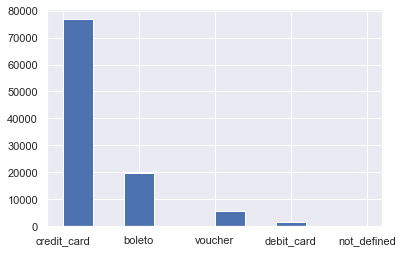

In [59]:
order_payments['payment_type'].hist()

# payment_installments
Nombre de versements choisis par le client.

Même si les clients préfèrent régler en une seul fois, ils sont quand même nombreux à payer en 2 ou 3 fois. des paiements plus échellonés étant plus rares.

In [60]:
order_payments['payment_installments'].describe()

count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

In [61]:
order_payments['payment_installments'].value_counts()

1     52546
2     12413
3     10461
4      7098
10     5328
5      5239
8      4268
6      3920
7      1626
9       644
12      133
15       74
18       27
11       23
24       18
20       17
13       16
14       15
17        8
16        5
21        3
0         2
23        1
22        1
Name: payment_installments, dtype: int64

## payment_value
Valeur de la transaction.

Le prix moyen d'une transaction est de 154,00 BRL avec un maximum de 13664,00 BRL. Ce paiement de 13664,00 BRL correspond une commande de 8 fois le même article. Peut-être s'agit-il de données dupliquées ?

In [62]:
order_payments['payment_value'].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

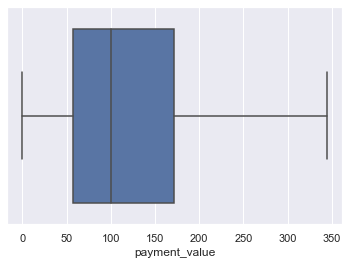

In [63]:
sns.boxplot(x=order_payments["payment_value"], showfliers=False)
plt.show()

**Une seule transaction supérieure à 13664,00 BRL**

In [64]:
order_payments[order_payments['payment_value'] > 12000]

order_id  payment_sequential payment_type  \
52107  03caa2c082116e1d31e67e9ae3700499                   1  credit_card   

       payment_installments  payment_value  
52107                     1       13664.08

In [65]:
order_items[order_items['order_id'] == '03caa2c082116e1d31e67e9ae3700499']

order_id  order_item_id  \
1647  03caa2c082116e1d31e67e9ae3700499              1   
1648  03caa2c082116e1d31e67e9ae3700499              2   
1649  03caa2c082116e1d31e67e9ae3700499              3   
1650  03caa2c082116e1d31e67e9ae3700499              4   
1651  03caa2c082116e1d31e67e9ae3700499              5   
1652  03caa2c082116e1d31e67e9ae3700499              6   
1653  03caa2c082116e1d31e67e9ae3700499              7   
1654  03caa2c082116e1d31e67e9ae3700499              8   

                            product_id                         seller_id  \
1647  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1648  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1649  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1650  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1651  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1652  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1653  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1654  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   

      shipping_limit_date   price  freight_value  
1647  2017-10-06 15:28:20  1680.0          28.01  
1648  2017-10-06 15:28:20  1680.0          28.01  
1649  2017-10-06 15:28:20  1680.0          28.01  
1650  2017-10-06 15:28:20  1680.0          28.01  
1651  2017-10-06 15:28:20  1680.0          28.01  
1652  2017-10-06 15:28:20  1680.0          28.01  
1653  2017-10-06 15:28:20  1680.0          28.01  
1654  2017-10-06 15:28:20  1680.0          28.01

# order_reviews
Ce jeu de données comprend des données sur les avis des clients.

Lorsqu'un client achète un produit chez Olist Store, un vendeur est informé de l'exécution de cette commande. Une fois que le client reçoit le produit, ou que la date de livraison prévue est fixée, il reçoit une enquête de satisfaction par courrier électronique où il peut donner une note pour l'expérience d'achat et noter quelques commentaires.

 - **review_id** : identifiant unique de l'enquête de satisfaction
 - **order_id** : identifiant unique de la commande
 - **review_score** : Note allant de 1 à 5, donnée par le client pendant une enquête de satisfaction.
 - **review_comment_title** : Titre du commentaire laissé par le client (en portugais).
 - **review_comment_message** : Message de commentaire de l'évaluation laissée par le client (en portugais).
 - **review_creation_date** : Indique la date à laquelle l'enquête de satisfaction a été envoyée au client.
 - **review_answer_timestamp** : indique l'horodatage de la réponse à l'enquête de satisfaction.

Tous les avis ont une note, mais pas forcément de commentaires. Il y a 99 173 avis uniques sur 100000 avis. Un avis peut être utilisé pour deux commandes différentes, ce qui est le cas pour 827 commandes. Une commande peut avoir plusieurs commentaires. C'est le cas pour 559 commandes.

La réponse à l'enquête est entre 2 heures et 518 jours (1,5 années) avec une moyenne de 2,5 jours

Création d'une nouvelle colonne **review_creation_answer_days** qui correspond au nombre de jours écoulés entre l'envoi de l'enquête de satisfaction et la réponse à l'enquête par le client.
Création de deux nouvelles colonnes **review_have_title** et **review_have_comment**

In [66]:
print(f"{order_reviews.shape[0]} lignes {order_reviews.shape[1]} colonnes")
display(order_reviews.info())
display(order_reviews.head())
print("Valeurs manquantes")
display(order_reviews.isnull().sum())

100000 lignes 7 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


None

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

Valeurs manquantes


review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

## review_id
Identifiant unique de l'enquête de satisfaction

In [67]:
unique_review = len(order_reviews['review_id'].unique())
review_count = order_reviews.shape[0]
print(f"{unique_review} avis uniques sur {review_count} publiés")

99173 avis uniques sur 100000 publiés


In [68]:
order_reviews[order_reviews.duplicated(['review_id'])].head()

review_id                          order_id  \
3337  3242cc306a9218d0377831e175d62fbf  9c5bfba7de6a4abbb6ba0baab78d1622   
5757  308316408775d1600dad81bd3184556d  3fe4dbcdb046a475dbf25463c1ca78bd   
7266  8ee90ac383cf825bb7f4756130d4e74a  75d5d3d16567a27eefc5752aeb063072   
7859  d433c252647c51309432ca0b763f969b  191abde9c3bf77d1ce67d100d8db6d15   
9077  03a6a25db577d0689440933055111897  3fde8b7313af6b37b84b5c7594d7add0   

      review_score review_comment_title  \
3337             5                  NaN   
5757             5                  NaN   
7266             5                  NaN   
7859             1                  NaN   
9077             5                  NaN   

                                 review_comment_message review_creation_date  \
3337                                             Ótimo   2017-07-21 00:00:00   
5757  Ajudem a rastrear uma das 3 prateleiras que fa...  2017-09-07 00:00:00   
7266                                          recomendo  2017-05-30 00:00:00   
7859                                                NaN  2017-09-03 00:00:00   
9077  Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...  2017-12-15 00:00:00   

     review_answer_timestamp  
3337     2017-07-22 01:06:37  
5757     2017-09-11 09:58:09  
7266     2017-06-02 18:16:17  
7859     2017-09-06 16:11:00  
9077     2017-12-16 01:32:18

In [69]:
order_reviews[order_reviews['review_id'] == '03a6a25db577d0689440933055111897']

review_id                          order_id  \
2000  03a6a25db577d0689440933055111897  2acfdc5131ff2cf4433e668454c9784c   
9077  03a6a25db577d0689440933055111897  3fde8b7313af6b37b84b5c7594d7add0   

      review_score review_comment_title  \
2000             5                  NaN   
9077             5                  NaN   

                                 review_comment_message review_creation_date  \
2000  Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...  2017-12-15 00:00:00   
9077  Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...  2017-12-15 00:00:00   

     review_answer_timestamp  
2000     2017-12-16 01:32:18  
9077     2017-12-16 01:32:18

## order_id
Identifiant unique de la commande


In [70]:
unique_order = len(order_reviews['order_id'].unique())
review_count = order_reviews.shape[0]
print(f"{unique_order} commandes uniques sur {review_count} avis")

99441 commandes uniques sur 100000 avis


In [71]:
order_reviews[order_reviews.duplicated(['order_id'])].head()

review_id                          order_id  \
1128  46abf3ea0b2710ad41390fdb79c32d84  5040757d4e06a4be96d3827b860b4e7c   
3127  aa193e76d35950c4ae988237bb36ed2b  cf73e2cb1f4a9480ed70c154da3d954a   
8164  40294ea5a778dc62080d6b3f55d361ce  e1bc1083cd7acd30d0576335373b907d   
9128  32e2c7e889f7a185d462265398ee3631  c7cfea0c153e6382e32e84c2a9dd7d2e   
9868  95a3135743556b117d888cc8c6e12e11  f9c78e6e58306dc81efbbada1ac11f24   

      review_score review_comment_title  \
1128             5                  NaN   
3127             5                  NaN   
8164             5                  NaN   
9128             5                  NaN   
9868             3                  NaN   

                                 review_comment_message review_creation_date  \
1128                                                NaN  2017-11-07 00:00:00   
3127                                                NaN  2018-01-18 00:00:00   
8164                                                NaN  2018-03-23 00:00:00   
9128                                                NaN  2017-10-21 00:00:00   
9868  O produto chegou antes do prazo mas recebi um ...  2017-09-14 00:00:00   

     review_answer_timestamp  
1128     2017-11-10 20:07:48  
3127     2018-01-18 17:36:45  
8164     2018-03-24 00:23:06  
9128     2017-10-22 00:47:25  
9868     2017-09-17 11:14:08

In [72]:
order_reviews[order_reviews['order_id'] == '5040757d4e06a4be96d3827b860b4e7c']

review_id                          order_id  \
1035  afd9b3d196f0acd81d79d8ccd79c2430  5040757d4e06a4be96d3827b860b4e7c   
1128  46abf3ea0b2710ad41390fdb79c32d84  5040757d4e06a4be96d3827b860b4e7c   

      review_score review_comment_title review_comment_message  \
1035             5                  NaN                    NaN   
1128             5                  NaN                    NaN   

     review_creation_date review_answer_timestamp  
1035  2017-10-31 00:00:00     2017-11-04 21:12:29  
1128  2017-11-07 00:00:00     2017-11-10 20:07:48

In [73]:
order_reviews[order_reviews['order_id'] == 'f9c78e6e58306dc81efbbada1ac11f24']

review_id                          order_id  \
4782  3c95105686e2ae71e8fd94b6483eba79  f9c78e6e58306dc81efbbada1ac11f24   
9868  95a3135743556b117d888cc8c6e12e11  f9c78e6e58306dc81efbbada1ac11f24   

      review_score review_comment_title  \
4782             2                  NaN   
9868             3                  NaN   

                                 review_comment_message review_creation_date  \
4782  comprei 4 cubas ao mesmo tempo, fui cobrada pe...  2017-09-19 00:00:00   
9868  O produto chegou antes do prazo mas recebi um ...  2017-09-14 00:00:00   

     review_answer_timestamp  
4782     2017-09-22 15:23:29  
9868     2017-09-17 11:14:08

## review_score
Note allant de 1 à 5, note donnée par le client pendant l'enquête de satisfaction.

Le score moyen est de 4, mais en majorité les clients mettent une note de 5 (57%)

In [74]:
order_reviews['review_score'].describe()

count    100000.000000
mean          4.070890
std           1.359663
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

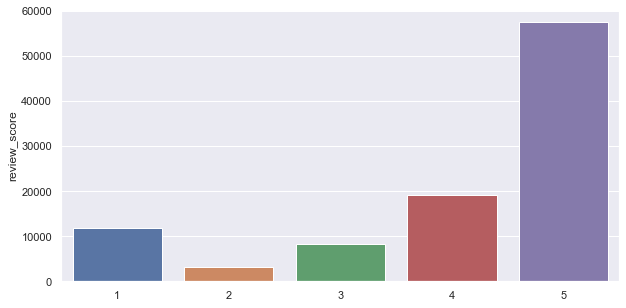

In [75]:
plt.figure(figsize=(10, 5))
sns.barplot(x=order_reviews["review_score"].value_counts().index,
            y=order_reviews["review_score"].value_counts())
plt.savefig('img/review_score.png')
plt.show()

In [76]:
order_reviews['review_score'].value_counts()

5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64

In [77]:
order_reviews['review_score'].value_counts(normalize=True)*100

5    57.420
4    19.200
1    11.858
3     8.287
2     3.235
Name: review_score, dtype: float64

## review_comment_title
Titre du commentaire laissé par le client (en portugais).

88% des clients ne laissent pas de titre dans les avis. Les avis ont entre 1 et 26 caractères de long

In [78]:
review_title_sum = order_reviews[
    'review_comment_title'].isnull().sum()
review_count = order_reviews.shape[0]
print(f"{review_title_sum} avis qui n'ont pas de titre sur {review_count}")

88285 avis qui n'ont pas de titre sur 100000


In [79]:
# Nouvelle variable
order_reviews['review_have_title'] = order_reviews.apply(
    lambda x: 0 if pd.isnull(x['review_comment_title']) else 1, axis=1)

In [80]:
review_min = order_reviews[
    'review_comment_title'].dropna().map(len).min()
review_max = order_reviews[
    'review_comment_title'].dropna().map(len).max()
review_count = order_reviews.shape[0]
print(f"Les avis ont entre {review_min} et {review_max} caractères de long")

Les avis ont entre 1 et 26 caractères de long


## review_comment_message
Message de commentaire de l'évaluation laissée par le client (en portugais).

58% des clients ne laissent pas de commentaire dans les avis. Les avis ont entre 1 et 208 caractères de long. Certains commentaires n'ont pas de titre.

In [81]:
review_cmt = order_reviews[
    'review_comment_message'].isnull().sum()
review_count = order_reviews.shape[0]

print(f"{review_cmt} avis qui n'ont pas de commentaire sur {review_count}")

58247 avis qui n'ont pas de commentaire sur 100000


In [82]:
review_min = order_reviews[
    'review_comment_message'].dropna().map(len).min()
review_max = order_reviews[
    'review_comment_message'].dropna().map(len).max()

print(f"Les avis ont entre {review_min} et {review_max} caractères de long")

Les avis ont entre 1 et 208 caractères de long


In [83]:
# Nouvelle variable
order_reviews['review_have_message'] = order_reviews.apply(
    lambda x: 0 if pd.isnull(x['review_comment_message']) else 1, axis=1)

## review_creation_date
Indique la date à laquelle l'enquête de satisfaction a été envoyée au client.

Les enquêtes ont été réalisées entre le 02/10/2016 et le 31/08/2018. Il y a plus de commentaires en 2018, quand 2016 ou en 2017

In [84]:
review_min = order_reviews['review_creation_date'].dropna().min()
review_max = order_reviews['review_creation_date'].dropna().max()

print(f"Les avis ont été demandés entre {review_min} et {review_max}")

Les avis ont été demandés entre 2016-10-02 00:00:00 et 2018-08-31 00:00:00


In [85]:
order_reviews['review_creation_date'] = \
    pd.to_datetime(order_reviews['review_creation_date'])

df = order_reviews.set_index('review_creation_date')
g = df.groupby(pd.Grouper(freq="Y", how='sum'))
g.sum()

review_score  review_have_title  review_have_message
review_creation_date                                                      
2016-12-31                    1162                  0                  244
2017-12-31                  176383                 11                18164
2018-12-31                  229544              11704                23345

## review_answer_timestamp
Indique l'horodatage de la réponse à l'enquête de satisfaction.

Les avis ont été donnés entre le 07/10/2016 et le 29/10/2018. On remarque qu'il y a une différence entre le demande et la réponse à l'enquête. En moyenne les clients répondent dans les 2,5 jours après la demande.

In [86]:
review_min = order_reviews['review_answer_timestamp'].dropna().min()
review_max = order_reviews['review_answer_timestamp'].dropna().max()

print(f"Les avis ont été donnés entre {review_min} et {review_max}")

Les avis ont été donnés entre 2016-10-07 18:32:28 et 2018-10-29 12:27:35


In [87]:
order_reviews['review_answer_timestamp'] = \
    pd.to_datetime(order_reviews['review_answer_timestamp'])
df = order_reviews.set_index('review_answer_timestamp')
g = df.groupby(pd.Grouper(freq="Y", how='sum'))
g.sum()

review_score  review_have_title  review_have_message
review_answer_timestamp                                                      
2016-12-31                       1108                  0                  237
2017-12-31                     173760                  0                17877
2018-12-31                     232221              11715                23639

### Difference en jours entre la date réponse à l'enquête et l'envoi de l'enquête au client

In [88]:
order_reviews['review_creation_answer_days'] = \
    (order_reviews['review_answer_timestamp'] -
     order_reviews['review_creation_date']).dt.days

In [89]:
order_reviews['review_creation_answer_days'].describe()

count    100000.00000
mean          2.58090
std           9.86328
min           0.00000
25%           1.00000
50%           1.00000
75%           3.00000
max         518.00000
Name: review_creation_answer_days, dtype: float64

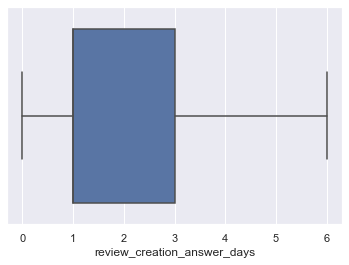

In [90]:
sns.boxplot(x=order_reviews["review_creation_answer_days"],
            showfliers=False)
plt.show()

# Orders
Il s'agit du jeu de données de base. A partir de chaque commande, vous pouvez trouver toutes les autres informations.

 - **order_id** : identifiant unique de la commande
 - **customer_id** : Identifiant du client. Chaque commande a un numéro de client unique.
 - **order_status** : Statut de la commande (livrée, expédiée, etc.).
 - **order_purchase_timestamp** : Horodatage de l'achat.
 - **order_approved_at** : indique l'horodatage de l'approbation du paiement.
 - **order_delivered_carrier_date** : Horodatage de l'enregistrement de la commande. Lorsque la commande a été traitée par le partenaire logistique.
 - **order_delivered_customer_date** : Date réelle de livraison de la commande au client.
 - **order_estimated_delivery_date** : Date de livraison estimée qui a été communiquée au client au moment de l'achat.
 
Création de 4 nouvelles colonnes : 
 - **order_purchase_approved_minutes** : nombre d'heures entre la commande et l'approbation de la commande
 - **order_purchase_carrier_days** : nombre de jours entre la date de la commande et l'enregistrement de la commande chez le partenaire logistique
 - **order_purchase_delivered_days** : nombre de jours entre la date de la commande à la livraison de la commande
 - **order_carrier_delivered_days**: nombre de jours entre la date d'enregistrement de la commande chez le partenaire logistique et la livraison de la commande
 - **order_delivered_estimated_days** : nombre de jours entre l'estimation de livraison et la livraison effective
 

In [91]:
print(f"{orders.shape[0]} lignes {orders.shape[1]} colonnes")
display(orders.info())
display(orders.head())
print("Valeurs manquantes")
display(orders.isnull().sum())

99441 lignes 8 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


None

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

Valeurs manquantes


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

## order_id
Identifiant unique de la commande

In [92]:
uniq_order = len(orders['order_id'].unique())
order_count = orders.shape[0]
print(f"{uniq_order} commandes uniques sur {order_count} commandes")

99441 commandes uniques sur 99441 commandes


## customer_id
Identifiant du client. Chaque commande a un numéro de client unique.

In [93]:
uniq_customer = len(orders['customer_id'].unique())
order_count = orders.shape[0]
print(f"{uniq_customer} clients uniques sur {order_count} commandes")

99441 clients uniques sur 99441 commandes


## order_status
Statut de la commande (livrée, expédiée, etc.).

Il y a 8 types d'état :
 - **delivered** : livrée
 - **invoiced** : facturée
 - **shipped** : livrée
 - **processing** : en cours de traitement
 - **unavailable** : non disponible,
 - **canceled** : annulée
 - **created** : crée
 - **approved** : approuvée

In [94]:
orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [95]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

## order_purchase_timestamp
Horodatage de l'achat.

Les commandes ont été passées entre le 04/09/2016 et le 17/10/2018. Le nombre de commandes est en augmnentation constante.

In [96]:
purchase_min = orders['order_purchase_timestamp'].min()
purchase_max = orders['order_purchase_timestamp'].max()

print(f"Les commandes ont été passée entre {purchase_min} et {purchase_max}")

Les commandes ont été passée entre 2016-09-04 21:15:19 et 2018-10-17 17:30:18


## order_approved_at
Horodatage de l'approbation du paiement.

In [97]:
amin = orders['order_approved_at'].dropna().min()
amax = orders['order_purchase_timestamp'].dropna().max()
print(f"Les commandes ont été approuvées entre {amin} et {amax}")

Les commandes ont été approuvées entre 2016-09-15 12:16:38 et 2018-10-17 17:30:18


In [98]:
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_count'] = 1
df = orders.set_index('order_approved_at')
g = df.groupby(pd.Grouper(freq="Y", how='sum'))
g.sum()

order_count
order_approved_at             
2016-12-31                 322
2017-12-31               44973
2018-12-31               53986

### Difference en minutes entre la date de la commande et l'approbation de la commande

In [99]:
orders['order_purchase_timestamp'] = \
    pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_purchase_approved_minutes'] =\
    (orders['order_approved_at'] -
     orders['order_purchase_timestamp']).dt.total_seconds().div(60)
orders['order_purchase_approved_minutes'].describe()

count     99281.000000
mean        625.145658
std        1562.280218
min           0.000000
25%          12.900000
50%          20.600000
75%         874.850000
max      270550.833333
Name: order_purchase_approved_minutes, dtype: float64

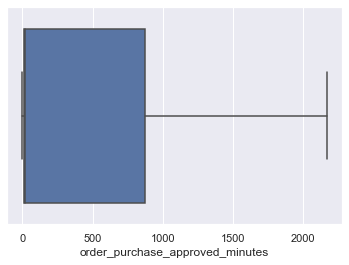

In [100]:
sns.boxplot(x=orders["order_purchase_approved_minutes"], showfliers=False)
plt.show()

## order_delivered_carrier_date
Horodatage de l'enregistrement de la commande. Lorsque la commande a été traitée par le partenaire logistique.

L'enregistrement des commandes est entre le 08/10/2016 et le 11/09/2018.

La différence entre la date de la commande et l'enregistrement de la commande est de moins d'une minutes à 125 jours. Lors de la conversion il est appararu que la différence pouvait être négative, cela est probablement du à un problème de synchronisation des horadages. Ces valeurs on été remplacées par des valeurs manquantes.


In [101]:
dmin = orders['order_delivered_carrier_date'].dropna().min()
dmax = orders['order_delivered_carrier_date'].dropna().max()

print(f"Les commandes ont été enregistrées entre {dmin} et {dmax}")

Les commandes ont été enregistrées entre 2016-10-08 10:34:01 et 2018-09-11 19:48:28


In [102]:
orders['order_delivered_carrier_date'] =\
    pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_count'] = 1
df = orders.set_index('order_delivered_carrier_date')
g = df.groupby(pd.Grouper(freq="Y", how='sum'))
g.sum()

order_count  order_purchase_approved_minutes
order_delivered_carrier_date                                              
2016-12-31                            281                     3.920111e+05
2017-12-31                          43328                     2.600642e+07
2018-12-31                          54049                     3.389336e+07

### Difference en minutes entre la date de la commande et l'enregistrement de la commande chez le partenaire logistique

In [103]:
orders['order_purchase_carrier_days'] =\
    (orders['order_delivered_carrier_date'] -
     orders['order_purchase_timestamp']).dt.days
# Les valeurs négative sont remplacée par NaN
orders.loc[orders['order_purchase_carrier_days'] < 0] = np.NaN
orders['order_purchase_carrier_days'].describe()

count    97492.000000
mean         2.751282
std          3.581764
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        125.000000
Name: order_purchase_carrier_days, dtype: float64

## order_delivered_customer_date
Date réelle de livraison de la commande au client.

L'enregistrement des commandes est entre le 11/10/2016 et le 11/09/2018.

La différence entre la date de la commande et la livraison de la commande est 12 heures à 209 jours et la différence entre la date d'enregistrement de la commande chez le transporteur et la livraison effective est de 0 heures à 205 jours, avec une moyenne de 8 jours.


In [104]:
emin = orders['order_delivered_customer_date'].dropna().min()
emax = orders['order_delivered_carrier_date'].dropna().max()
print(f"Les commandes ont été livrées entre {emin} et {emax}")

Les commandes ont été livrées entre 2016-10-11 13:46:32 et 2018-09-11 19:48:28


In [105]:
orders['order_delivered_customer_date'] =\
    pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_count'] = 1
df = orders.set_index('order_delivered_customer_date')
g = df.groupby(pd.Grouper(freq="Y", how='sum'))
g.sum()

order_count  order_purchase_approved_minutes  \
order_delivered_customer_date                                                 
2016-12-31                             272                     3.366633e+05   
2017-12-31                           40930                     2.431352e+07   
2018-12-31                           55109                     3.481507e+07   

                               order_purchase_carrier_days  
order_delivered_customer_date                               
2016-12-31                                          3646.0  
2017-12-31                                        115197.0  
2018-12-31                                        145515.0

### Difference en jours entre la date de la commande et la date de livraison de la commande

In [106]:
orders['order_purchase_delivered_days'] =\
    (orders['order_delivered_customer_date'] -
     orders['order_purchase_timestamp']).dt.total_seconds().div(60)

orders['order_purchase_delivered_days'].describe()

count     96311.000000
mean      18097.392294
std       13752.490790
min         768.116667
25%        9754.983333
50%       14725.400000
75%       22653.358333
max      301865.200000
Name: order_purchase_delivered_days, dtype: float64

### Difference en jours entre la date d'enregistrement de la commande chez le partenaire logistique et la date de  livraison de la commande

In [107]:
orders['order_carrier_delivered_days'] =\
    (orders['order_delivered_customer_date'] -
     orders['order_delivered_carrier_date']).dt.days
# Les valeurs négative sont remplacée par NaN
orders.loc[orders['order_carrier_delivered_days'] < 0] = np.NaN
orders['order_carrier_delivered_days'].describe()

count    96287.000000
mean         8.882611
std          8.732815
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        205.000000
Name: order_carrier_delivered_days, dtype: float64

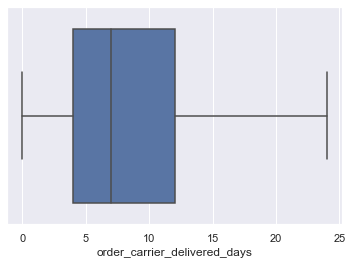

In [108]:
sns.boxplot(x=orders["order_carrier_delivered_days"], showfliers=False)
plt.show()

## order_estimated_delivery_date
Date de livraison estimée qui a été communiquée au client au moment de l'achat.

L'estimation de livraison des commandes est entre le 30/09/2016 et le 11/12/2018.


 - 87 005 estimations sont au-dessus de la livraison réelle
 - 7 824 estimations sont en-dessous de la livraison réelle
 - 1 459 estimations sont exactes avec la livraison réelle



In [109]:
emin = orders['order_estimated_delivery_date'].dropna().min()
emax = orders['order_estimated_delivery_date'].dropna().max()
print(f"Les commandes ont été estimées livrées entre {emin} et {emax}")

Les commandes ont été estimées livrées entre 2016-09-30 00:00:00 et 2018-11-12 00:00:00


In [110]:
orders['order_estimated_delivery_date'] =\
    pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_count'] = 1
df = orders.set_index('order_estimated_delivery_date')
g = df.groupby(pd.Grouper(freq="Y", how='sum'))
g.sum()

order_count  order_purchase_approved_minutes  \
order_estimated_delivery_date                                                 
2016-12-31                             322                     8.126602e+05   
2017-12-31                           40298                     2.427240e+07   
2018-12-31                           58632                     3.694573e+07   

                               order_purchase_carrier_days  \
order_estimated_delivery_date                                
2016-12-31                                          3720.0   
2017-12-31                                        113437.0   
2018-12-31                                        150850.0   

                               order_purchase_delivered_days  \
order_estimated_delivery_date                                  
2016-12-31                                      7.480634e+06   
2017-12-31                                      7.021844e+08   
2018-12-31                                      1.033086e+09   

                               order_carrier_delivered_days  
order_estimated_delivery_date                                
2016-12-31                                           1484.0  
2017-12-31                                         338243.0  
2018-12-31                                         515553.0

### Difference entre l'estimation de livraison et la livraison effective

In [111]:
orders['order_delivered_estimated_days'] =\
    (orders['order_estimated_delivery_date'] -
     orders['order_delivered_customer_date'])\
    .dt.days
orders['order_delivered_estimated_days'].describe()

count    96288.000000
mean        10.867668
std         10.183103
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: order_delivered_estimated_days, dtype: float64

In [112]:
esup = len(orders[orders['order_delivered_estimated_days'] > 0])
esub = len(orders[orders['order_delivered_estimated_days'] < 0])
ematch = len(orders[orders['order_delivered_estimated_days'] == 0])

print(f"{esup} estimations au dessus de la livraison réelle")
print(f"{esub} estimations en dessous de la livraison réelle")
print(f"{ematch} estimations exactent avec la livraison réelle")

87005 estimations au dessus de la livraison réelle
7824 estimations en dessous de la livraison réelle
1459 estimations exactent avec la livraison réelle


In [113]:
orders['estimated'] =\
    pd.to_datetime(
        orders['order_estimated_delivery_date'].dropna()).astype(int) / 10**9
orders['delivered'] =\
    pd.to_datetime(
        orders['order_delivered_customer_date'].dropna()).astype(int) / 10**9

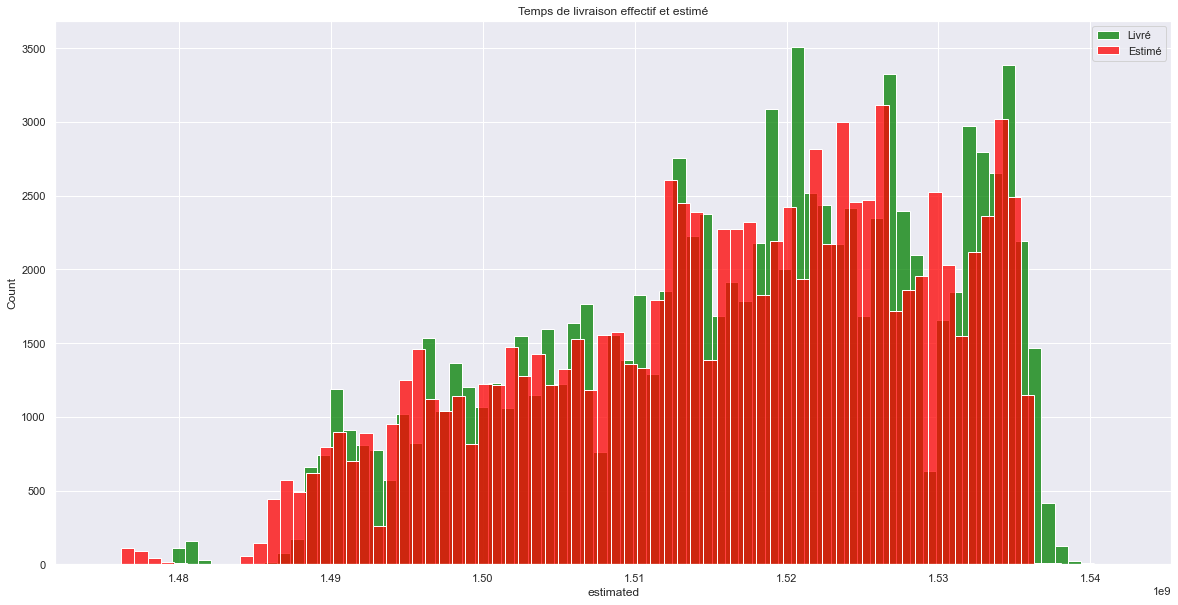

In [114]:
plt.figure(figsize=(20, 10))
plt.title("Temps de livraison effectif et estimé")
sns.histplot(orders['estimated'].dropna(), label='Livré', color='green')
sns.histplot(orders['delivered'].dropna(), label='Estimé', color='red')
plt.legend()
plt.savefig('img/delivery.png')
plt.show()

# Products
Ce jeu de données comprend des données sur les produits vendus par **Olist**.

 - **product_id** : identifiant unique du produit
 - **product_category_name** : catégorie de base du produit (en portugais).
 - **product_name_lenght** : nombre de caractères pour le nom du produit.
 - **product_description_lenght** : nombre de caractères pour la description du produit.
 - **product_photos_qty** : nombre de photos publiées du produit
 - **product_weight_g** : poids du produit mesuré en grammes.
 - **product_length_cm** : longueur du produit mesurée en centimètres.
 - **product_height_cm** : hauteur du produit mesurée en centimètres.
 - **product_width_cm** : largeur du produit mesurée en centimètres.

Création d'une nouvelle colonne **product_volume**


In [115]:
print(f"{products.shape[0]} lignes {products.shape[1]} colonnes")
display(products.info())
display(products.head())
print("Valeurs manquantes")
display(products.isnull().sum())

32951 lignes 9 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


None

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

Valeurs manquantes


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

## product_id
Identifiant unique du produit

In [116]:
uniq_pro = len(products['product_id'].unique())
prod_count = products.shape[0]
print(f"{uniq_pro} produits uniques sur {prod_count} produits")

32951 produits uniques sur 32951 produits


## product_category_name
Catégorie de base du produit (en portugais).


In [117]:
uniq_cat = len(products['product_category_name'].unique())
prod_count = products.shape[0]
print(f"{uniq_cat} de categories sur {prod_count} produits")

74 de categories sur 32951 produits


In [118]:
products['product_category_name'].value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 73, dtype: int64

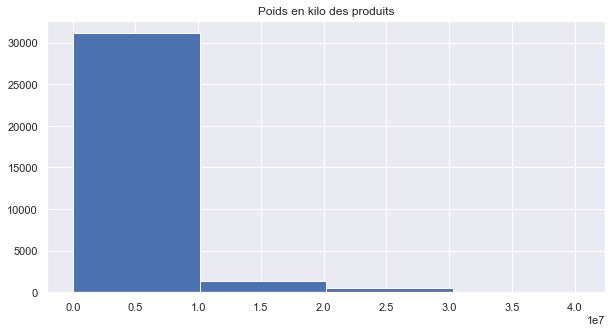

In [119]:
p = products['product_weight_g'] * 1000

plt.figure(figsize=(10, 5))
plt.title('Poids en kilo des produits')
p.hist(bins=4)

No handles with labels found to put in legend.


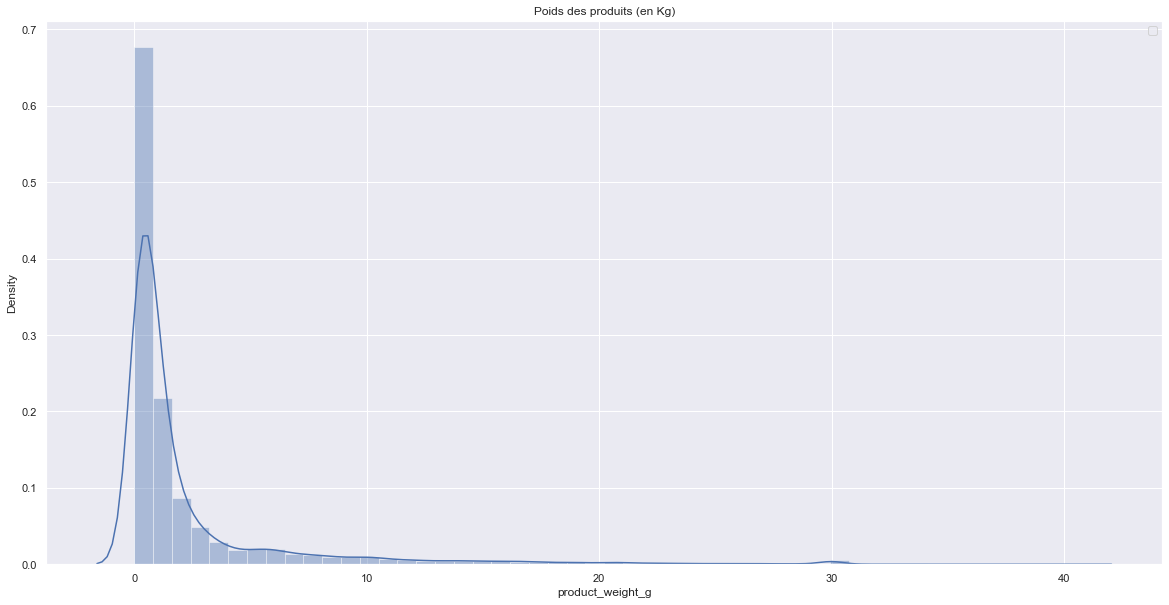

In [120]:
p = products['product_weight_g'] / 1000
plt.figure(figsize=(20, 10))
plt.title("Poids des produits (en Kg)")
sns.distplot(p.dropna())
plt.legend()
plt.savefig('img/delivery.png')
plt.show()

## product_name_lenght
Nombre de caractères pour le nom du produit.

En moyenne le nombre de caractères pour le nom du produit est 48, avec un minimum de 5 caractères et un maximum de 76 caractères.

In [121]:
products['product_name_lenght'].describe()

count    32341.000000
mean        48.476949
std         10.245741
min          5.000000
25%         42.000000
50%         51.000000
75%         57.000000
max         76.000000
Name: product_name_lenght, dtype: float64

## product_description_lenght
Nombre de caractères pour la description du produit.

En moyenne le nombre de caractères pour le description du produit est 771, avec un minimum de 4 caractères et un maximum de 3992 caractères.

In [122]:
products['product_description_lenght'].describe()

count    32341.000000
mean       771.495285
std        635.115225
min          4.000000
25%        339.000000
50%        595.000000
75%        972.000000
max       3992.000000
Name: product_description_lenght, dtype: float64

## product_photos_qty
Nombre de photos publiées du produit

En moyenne un produit a 2 photos, avec un minimum de 1 photo et un maximum de 20 photos.


In [123]:
products['product_photos_qty'].describe()

count    32341.000000
mean         2.188986
std          1.736766
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         20.000000
Name: product_photos_qty, dtype: float64

## product_weight_g
Poids du produit mesuré en grammes.

En moyenne un produit pèse 2 Kilo, avec un minimum de 0 gramme et un maximum de 40 Kilo.


In [124]:
products['product_weight_g'].describe()

count    32949.000000
mean      2276.472488
std       4282.038731
min          0.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64

## product_length_cm
Longueur du produit mesurée en centimètres.

En moyenne un produit a une longueur de 30 centimètres, avec un minimum de 7 centimètres et un maximum de 1 mètre.

In [125]:
products['product_length_cm'].describe()

count    32949.000000
mean        30.815078
std         16.914458
min          7.000000
25%         18.000000
50%         25.000000
75%         38.000000
max        105.000000
Name: product_length_cm, dtype: float64

## product_height_cm
Hauteur du produit mesurée en centimètres.

En moyenne un produit a une hauteur de 16 centimètres, avec un minimum de 2 centimètres et un maximum de 1 mètre.

In [126]:
products['product_height_cm'].describe()

count    32949.000000
mean        16.937661
std         13.637554
min          2.000000
25%          8.000000
50%         13.000000
75%         21.000000
max        105.000000
Name: product_height_cm, dtype: float64

## product_width_cm
Largeur du produit mesurée en centimètres.

En moyenne un produit a une largeur de 23 centimètres, avec un minimum de 6 centimètres et un maximum de 1,18 mètre.

In [127]:
products['product_width_cm'].describe()

count    32949.000000
mean        23.196728
std         12.079047
min          6.000000
25%         15.000000
50%         20.000000
75%         30.000000
max        118.000000
Name: product_width_cm, dtype: float64

# Volume
Nouvelle colonne volume

En moyenne un produit a un volume de 16564 $cm^3$, avec un minimum de 168 $cm^3$ et un maximum de 0,3 $m^3$.


In [128]:
products['product_volume'] = \
    products['product_length_cm'] *\
    products['product_height_cm'] *\
    products['product_width_cm']

In [129]:
products['product_volume'].describe()

count     32949.000000
mean      16564.096695
std       27057.041650
min         168.000000
25%        2880.000000
50%        6840.000000
75%       18480.000000
max      296208.000000
Name: product_volume, dtype: float64

# Sellers
Ce jeu de données comprend des données sur les vendeurs qui ont honoré les commandes passées sur **Olist**. 
Utilisez-les pour trouver l'emplacement du vendeur et pour identifier quel vendeur a vendu quel produit.

 - **seller_id** : identifiant unique du vendeur
 - **seller_zip_code_prefix** : les 5 premiers chiffres du code postal du vendeur
 - **seller_city** : nom de la ville du vendeur
 - **seller_state** : état dans le lequel de trouve le vendeur

Il y a 3095 vendeurs référencés chez **Olist** dans 611 villes. La pluspart des vendeurs sont au Brésil sauf une petite minorité qui est située en Argentine.

Les vendeurs sont répartis sur 23 états sur 27

In [130]:
print(f"{sellers.shape[0]} lignes {sellers.shape[1]} colonnes")
display(sellers.info())
display(sellers.head())
print("Valeurs manquantes")
display(sellers.isnull().sum())

3095 lignes 4 colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


None

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

Valeurs manquantes


seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

## seller_id
Identifiant unique du vendeur

In [131]:
uniq_seller = len(sellers['seller_id'].unique())
seller_count = sellers.shape[0]
print(f"{uniq_seller} vendeurs uniques sur {seller_count} vendeurs")

3095 vendeurs uniques sur 3095 vendeurs


## seller_zip_code_prefix
Les 5 premiers chiffres du code postal du vendeur

In [132]:
print(f"{len(sellers['seller_zip_code_prefix'].unique())} Code postaux")

2246 Code postaux


## seller_city
Nom de la ville du vendeur

In [133]:
print(f"{len(sellers['seller_city'].unique())} villes")

611 villes


## seller_state
Etat dans le lequel de trouve le vendeur.

Le vendeurs sont situés principalement dans l'état de Sao Polo 

In [134]:
print(f"{len(sellers['seller_state'].unique())} états sur 27 états")

23 états sur 27 états


In [135]:
print(f"Répartition par état : \n{sellers['seller_state'].value_counts()}")

Répartition par état : 
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
RO       2
SE       2
AM       1
PI       1
MA       1
AC       1
PA       1
Name: seller_state, dtype: int64


In [136]:
sellers = sellers.merge(
    geolocation[[
        'geolocation_lat',
        'geolocation_lng',
        'geolocation_zip_code_prefix']],
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
sellers.drop('geolocation_zip_code_prefix', axis=1, inplace=True)
brazil_map = folium.Map(
    location=[-14.242914500000001, -53.1892665], zoom_start=4)
sellers = sellers.dropna()
heat_data = [[row['geolocation_lat'],
              row['geolocation_lng']]
             for index, row in sellers.iterrows()]
HeatMap(heat_data).add_to(brazil_map)
brazil_map

# Regroupement des jeux de données
Le jeu de données **orders** contient toutes les données des autres jeux de données. Auquel on a ajouté les nouvelles variables.

In [137]:
orders = olist.merge_dataset()

# Valeurs manquantes

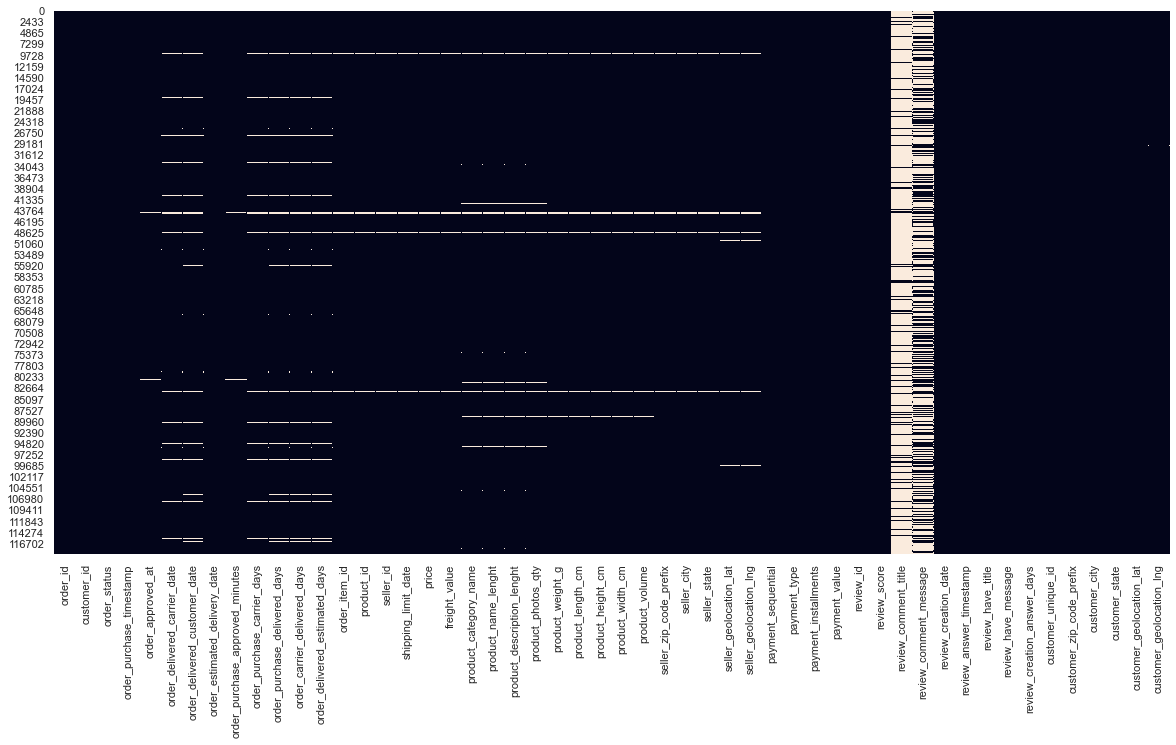

In [138]:
plt.figure(figsize=(20, 10))
sns.heatmap(orders.isnull(), cbar=False)
plt.savefig('img/isna_data.png')
plt.show()

In [139]:
orders.isnull().sum()

order_id                                0
customer_id                             0
order_status                            0
order_purchase_timestamp                0
order_approved_at                     177
order_delivered_carrier_date         2086
order_delivered_customer_date        3420
order_estimated_delivery_date           0
order_purchase_approved_minutes       177
order_purchase_carrier_days          2086
order_purchase_delivered_days        3420
order_carrier_delivered_days         3421
order_delivered_estimated_days       3420
order_item_id                         833
product_id                            833
seller_id                             833
shipping_limit_date                   833
price                                 833
freight_value                         833
product_category_name                2540
product_name_lenght                  2540
product_description_lenght           2540
product_photos_qty                   2540
product_weight_g                  

L'analyse des valeurs manquantes nous montre que certaines valeurs manquantes sont justifiées comme par exemple pour les variables **order_delivered_carrier_date**, **order_estimated_delivery_date**,**order_estimated_delivery_date** cela dénote que la commande est en cours de traitement. 

# Conclusion
Ce jeu de données concerne la période du 09/04/2016 au 17/10/2018. 

## Clients
Les clients habitent prinicpalement au Brésil dans les états de Sao Paulo et de Rio de Janeiro. On remarque par aileurs que quelques clients sont au Portugal ou dans les pays limitrophes du Brésil.


## Commandes
Il  y a 99 441 commandes au total dont 329 en 2016, 45 101 en 2017 et 54 011 en 2018. La plupart des clients passent une seule commande car ils sont 2997 à avoir passé plus de 2 commandes sur le site de Olist. De même que la plupart des commandes ne comportent qu'une seule ligne. 

Le délai entre la date de la commande et l'enregistrement de la commande est de moins d'une minutes à 125 jours. 

Le délai entre la date de la commande et la livraison de la commande est 12 heures à 209 jours et le délai entre la date d'enregistrement de la commande chez le transporteur et la livraison effective est de 0 heures à 205 jours, avec une moyenne de 8 jours.

L'estimation de livraison des commandes :

 - 87 005 estimations sont au-dessus de la livraison réelle
 - 7824 estimations sont en-dessous de la livraison réelle
 - 1459 estimations sont exactes avec la livraison réelle

Les prix des produits achétés sont dans une fourchette de 0.85 à 6735 Réal brésilien (BRL). Le prix moyen est de 120,65 BRL. Le panier moyen (hors frêt) est de 137,75 BRL avec un minium de 0,85 BRL et un maximum de 13440 BRL. Le frêt est aussi un élément important puisqu'il peut être gratuit mais aussi monter jusqu'a 1794,96 BRL.

Les catégories d'articles les plus vendues sont :
 - lit, table et bain
 - beauté santé
 - loisirs sportifs
 - décoration de meubles
 - accessoires d'ordinateur

et celles les moins vendues
 - assurances et services
 - vêtements pour enfants et adolescents
 - PC gamer
 - la cuisine
 - musique cd et dvd

Les clients n'ayant passé qu'une seule commande ont achété les catégories d'articles suivants : 
 - meubles et décorations
 - lit, table et bain
 - accessoires d'ordinateur
 - articles ménagers
 - loisirs sportifs


Le type de paiement est principalement par carte de crédit. Les autres moyens de paiement sont le Boleto, par bon d'achat, par carte de débit ou non défini.

> Boleto Bancário, communément appelé Boleto, est un moyen de paiement en espèces très populaire au Brésil, qui représente 15 % de part de marché. C'est aussi le seul moyen de paiement dont disposent 35 % des consommateurs qui ne possèdent pas de compte bancaire.
>
>Le paiement s'effectue par l'intermédiaire d'un coupon, délivré lors du règlement et payé à une banque brésilienne ou un magasin participant, sur internet ou sur mobile.

Les clients ont la possibilité de payer avec plusieurs modes de paiement lors de la commande, même si ceux-ci paient en général avec un seul moyen de paiement à 87% les autres utilisent des bons d'achat comme autre moyen de paiement. 

Il est aussi possible de commander en plusieurs fois, même si cela est très peu utilisé, l'échelonement des paiements va de 2 à 22 fois, avec une majorité en 2 ou 3 fois.

Le panier moyen est de 154,10 BRL.

## Produits
En moyenne un produit a 2 photos, avec un minimum de 1 photo et un maximum de 20 photos. Les dimensions moyennes sont $30x23x16$ centimètres, le volume moyen est de $0,01 m^3$ avec un minimum de $168 cm^3$ et un maximum de $0,3 m^3$.  

En moyenne un produit pèse 2 Kilo, avec un minimum de 0 gramme et un maximum de 40 Kilo. 
En moyenne un produit a une longueur de 30 centimètres, avec un minimum de 7 centimètres et un maximum de 1 mètre. 
En moyenne un produit a une hauteur de 16 centimètres, avec un minimum de 2 centimètres et un maximum de 1 mètre.
En moyenne un produit a une largeur de 23 centimètres, avec un minimum de 6 centimètres et un maximum de 1,18 mètre.
En moyenne un produit a un volume de 16564 centimètres cube, avec un minimum de 168 centimètres cube et un maximum de 0,3 mètres cube.


## Avis
Les avis sont receuillis par enquête de satisfaction.
Tous les clients donnent leur avis ou au moins une note, mais pas forcément de commentaire. Ils ont tendance à mettre une note de 4 ou de 5 dans 76% des cas. 58% des clients ne laissent pas de commentaire dans les avis. On note cependant que les clients laissent plus de commentaires au fur et à mesure des années.

Un client répond en moyenne en 2,5 jours à l'enquête de satisfaction.

## Vendeurs
Il y a 3095 vendeurs référencés chez Olist dans 611 villes. La pluspart des vendeurs sont au Brésil sauf une petite minorité qui est située en Argentine. Les vendeurs sont répartis dans 23 états sur 27

## Traitement des données
De nouvelles informations en été crées :

 - **order_purchase_approved_minutes** : nombre d'heures entre la commande et l'approbation de la commande
 - **order_purchase_carrier_days** : nombre de minutes entre la date de la commande et l'enregistrement de la commande chez le partenaire logistique
 - **order_purchase_delivered_days** : nombre de minutes entre la date de la commande à la livraison de la commande
 - **order_carrier_delivered_days**: nombre de minutes entre la date d'enregistrement de la commande chez le partenaire logistique et la livraison de la commande
 - **order_delivered_estimated_days** : nombre de minutes entre l'estimation de livraison et la livraison effective 
 - **product_volume** : volume d'un produit
 - **review_creation_answer_days** : nombre de jours entre le l'envoi de l'enquête de satisfaction et la réponse à l'enquête par le client
 - **review_have_title** : est-ce que le client a laissé un titre à son avis ?
 - **review_have_message** : est-ce que le client a laissé un texte à son avis ?
  
L'analyse des valeurs manquantes nous a montré que certaines valeurs manquantes sont justifiées comme par exemples pour les variables **order_delivered_carrier_date**, **order_estimated_delivery_date**,**order_estimated_delivery_date** cela dénotant que la commande est en cours de traitement.

Pour les variables **review_comment_title** et **review_comment_message** montrent que le client ne laissent pas forcément de commentaires lors de l'évaluation de sa commmande. Deux variables (**review_have_title** et **review_have_message**) sont créées pour définir si le client à laisser un titre ou un commentaire.

